In [30]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [31]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Importación de las imágenes

In [33]:
data_dir = '../Data/train_eyes'
batch_size = 16
img_height = 180
img_width = 180

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 988 files for training.


In [35]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 246 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)

['Closed', 'Open']


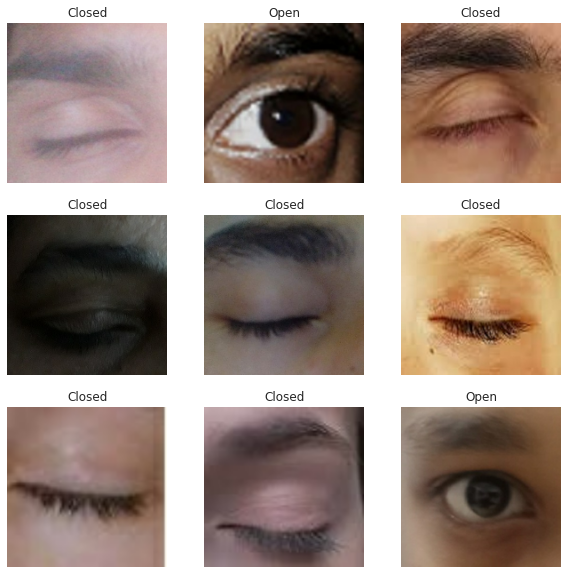

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache()
val_ds = val_ds.cache()

## Creación del modelo

In [40]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=100, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 45, 45, 64)       

## Entrenamiento

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 4s 32ms/step - loss: 0.9357 - accuracy: 0.7206 - val_loss: 0.2361 - val_accuracy: 0.9106
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 0.2325 - accuracy: 0.9170 - val_loss: 0.1982 - val_accuracy: 0.9228
Epoch 3/10
62/62 [==============================] - 1s 22ms/step - loss: 0.1477 - accuracy: 0.9464 - val_loss: 0.1453 - val_accuracy: 0.9431
Epoch 4/10
62/62 [==============================] - 1s 22ms/step - loss: 0.0949 - accuracy: 0.9595 - val_loss: 0.1608 - val_accuracy: 0.9268
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 0.0857 - accuracy: 0.9686 - val_loss: 0.1456 - val_accuracy: 0.9268
Epoch 6/10
62/62 [==============================] - 1s 22ms/step - loss: 0.0905 - accuracy: 0.9605 - val_loss: 0.2335 - val_accuracy: 0.9187
Epoch 7/10
62/62 [==============================] - 1s 22ms/step - loss: 0.1295 - accuracy: 0.9514 - val_loss: 0.2170 - val_accuracy: 0.9309
Epoch 8/10
62

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

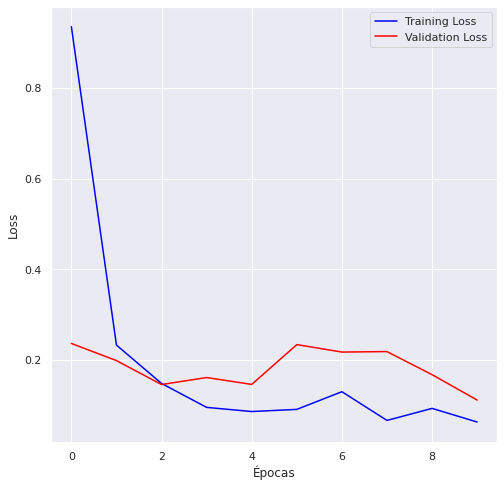

In [45]:
import seaborn as sns
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=loss, ax = ax, color="b", label='Training Loss')
sns.lineplot(data=val_loss, ax = ax, color="r", label='Validation Loss')
ax.set_xlabel("Épocas")
ax.set_ylabel("Loss")
plt.savefig("lineplot.png")

In [46]:
model.save('modelo.h5')

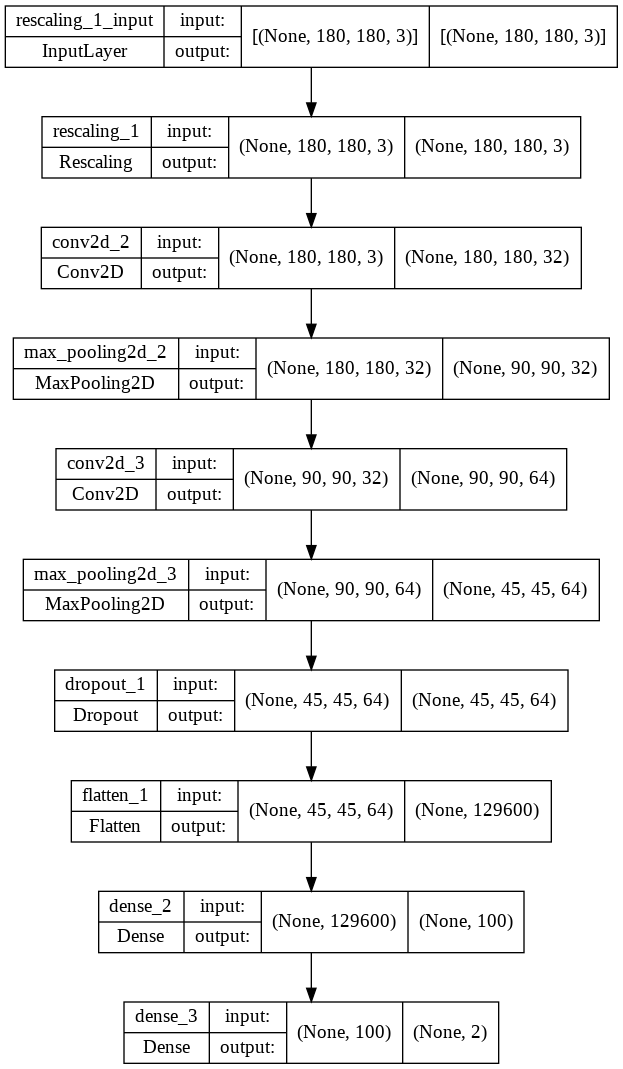

In [47]:
tf.keras.utils.plot_model(model, to_file="modelo.png", show_shapes=True, show_layer_names=True)

In [48]:
test_dir = '../Data/test_eyes'

In [49]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=100,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 218 files belonging to 2 classes.


In [50]:
Y_test = np.array([])
for image_batch, labels_batch in test_ds:
  labels = np.array(labels_batch)
  Y_test = np.append(Y_test, labels)

In [51]:
Y_test = Y_test.astype(int)
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
predictions = model.predict(test_ds)

In [53]:
Y_pred = np.argmax(predictions,axis=-1)

In [54]:
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [55]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.png")

In [56]:
cm = confusion_matrix(y_true= Y_test, y_pred=Y_pred)

Confusion matrix, without normalization
[[105   4]
 [  6 103]]


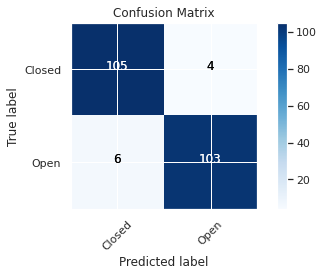

In [57]:
cm_plot_labels=["Closed", "Open"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [58]:
print(classification_report(Y_test,y_pred=Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       109
           1       0.96      0.94      0.95       109

    accuracy                           0.95       218
   macro avg       0.95      0.95      0.95       218
weighted avg       0.95      0.95      0.95       218

